<a href="https://colab.research.google.com/github/Ana-PNA/Ana-PNA/blob/main/C%C3%B3pia_de_lab1_amostragem_quantiza_o_interpola_o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB1 — Amostragem, Quantização, Resolução e Interpolação

Disciplina: **Processamento Digital de Imagens (PDI)**  - UFPel  
Professor: **Guilherme Corrêa**  

Este notebook introduz e pratica os conceitos de **amostragem espacial**, **quantização**, **resolução** e **interpolação**.

**Objetivos**
- Carregar e visualizar imagens em escala de cinza.
- Aplicar **amostragem** (redução da resolução espacial) com e sem anti-aliasing.
- Aplicar **quantização** (redução do número de níveis/bit-depth) e avaliar distorção (PSNR).
- Implementar **interpolação** por **vizinho mais próximo** e **bilinear**; usar **bicúbica** como referência.
- Discutir a relação entre **resolução**, **amostragem** e **interpolação**.

## 0) Ambiente e bibliotecas
Se estiver no Colab, rode a célula de instalação uma única vez.

In [1]:
# Se necessário no Colab, descomente a linha abaixo:
!pip -q install numpy matplotlib scikit-image imageio

In [2]:
import os, math
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_ubyte
from skimage.transform import resize
from skimage import data
from skimage.transform import resize as sk_resize

os.makedirs('data', exist_ok=True)
plt.rcParams['figure.dpi'] = 120

## 1) Utilitários
- Leitura sempre em **grayscale** (2D) quando desejado.
- Cálculo de **PSNR** para avaliar perda de qualidade devido à quantização e reamostragem.
- Visualização lado a lado.

In [3]:
def read_gray(path):
    img = io.imread(path)
    if img.ndim == 3:
        img = color.rgb2gray(img)  # float64 [0,1]
    img = img.astype(np.float32)   # passa para float32
    return img

def psnr(x, y, data_range=1.0):  # calcula a qualidade da imagem em comparação com outra
    x = x.astype(np.float32)
    y = y.astype(np.float32)
    mse = np.mean((x - y)**2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(data_range) - 10 * np.log10(mse)

def show2(a, b, titles=("A","B"), cmaps=('gray','gray')):
    fig, axs = plt.subplots(1,2, figsize=(8,3))
    axs[0].imshow(a, cmap=cmaps[0]); axs[0].set_title(titles[0]); axs[0].axis('off')
    axs[1].imshow(b, cmap=cmaps[1]); axs[1].set_title(titles[1]); axs[1].axis('off')
    plt.show()

## 2) Dados de exemplo
Usaremos `camera` como imagem base (grayscale).

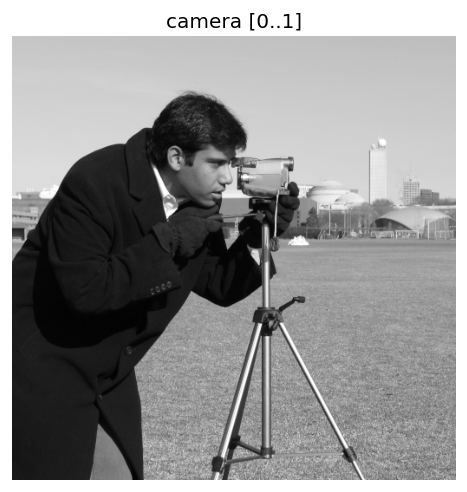

shape: (512, 512) dtype: float32


In [4]:
img0 = data.camera().astype(np.float32) / 255.0
io.imsave('data/camera.png', img_as_ubyte(img0))
plt.imshow(img0, cmap='gray'); plt.title('camera [0..1]'); plt.axis('off'); plt.show()
print('shape:', img0.shape, 'dtype:', img0.dtype)

## 3) Amostragem (downsampling) e anti-aliasing
A redução de resolução pode causar **aliasing**. Uma prática comum é **suavizar** (filtro passa-baixas) antes de dizimar.

Abaixo implementamos downsampling simples e com anti-aliasing (Gaussiano).

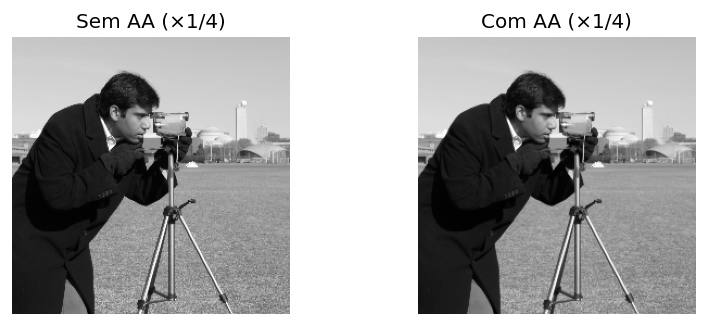

In [12]:
from scipy.ndimage import gaussian_filter

def downsample(img, factor, anti_alias=False, sigma=1.0):
    x = img
    if anti_alias:
        x = gaussian_filter(x, sigma=sigma)
    out = x[::factor, ::factor]
    return out

small_na = downsample(img0, factor=2, anti_alias=False)
small_aa = downsample(img0, factor=2, anti_alias=True, sigma=0.5)
show2(small_na, small_aa, ("Sem AA (×1/4)", "Com AA (×1/4)"))

### **Exercício A** — Downsampling e anti-aliasing
1. Experimente `factor = 2, 4, 8` e valores de `sigma` diferentes (ex.: 0.5, 1.0, 1.5).

## 4) Quantização (redução de níveis / bit-depth)
A quantização reduz o número de níveis radiométricos. Testaremos **quantização uniforme** e avaliaremos **PSNR**.

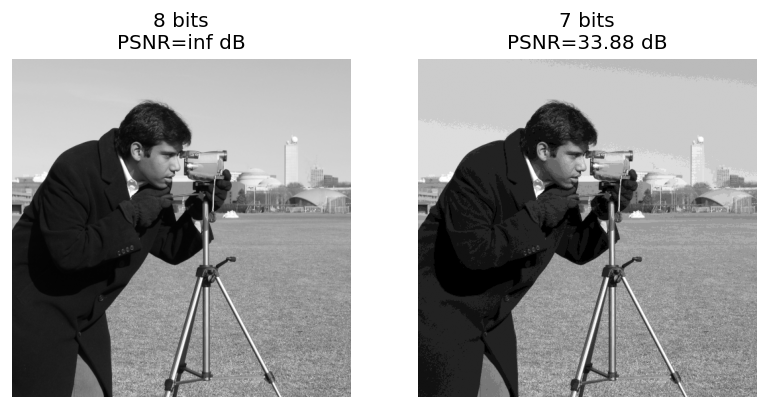

In [36]:
def quantize_uniform(img0, bits=2):
    levels = 2 ** bits
    # mapeia [0,1] para [0, levels-1], arredonda e volta para [0,1]
    q = np.round(img0 * (levels - 1)) / (levels - 1)
    return q.astype(np.float32)

q7 = quantize_uniform(img0, bits=4)

fig, axs = plt.subplots(1,2, figsize=(8,4))
for ax, im, b in zip(axs, [img0, q7], [8,7]):
    ax.imshow(im, cmap='gray'); ax.set_title(f'{b} bits\nPSNR={psnr(img0, im):.2f} dB'); ax.axis('off')
plt.show()

### **Exercício B** — Comparação Visual da Quantização
1. Compare visualmente quantizações com **2, 3, 4, 6 e 8 bits**.

## 5) Interpolação — NN e Bilinear
A seguir, implementamos o interpoladores de **vizinho mais próximo** e **bilinear** para praticar o mapeamento de coordenadas.

In [37]:
def resize_nn(img, sx, sy):
    h_in, w_in = img.shape
    h_out = int(round(h_in * sy))
    w_out = int(round(w_in * sx))
    out = np.zeros((h_out, w_out), dtype=img.dtype)
    ys = np.arange(h_out)
    xs = np.arange(w_out)
    y_src = (ys + 0.5) / sy - 0.5
    x_src = (xs + 0.5) / sx - 0.5
    y_nn = np.clip(np.round(y_src).astype(int), 0, h_in - 1)
    x_nn = np.clip(np.round(x_src).astype(int), 0, w_in - 1)
    for j_out, j_in in enumerate(y_nn):
        out[j_out, :] = img[j_in, x_nn]
    return out

In [38]:
def resize_bilinear(img, sx, sy):
    h_in, w_in = img.shape
    h_out = int(round(h_in * sy))
    w_out = int(round(w_in * sx))
    ys = np.arange(h_out)
    xs = np.arange(w_out)
    y_src = (ys + 0.5) / sy - 0.5
    x_src = (xs + 0.5) / sx - 0.5
    y0 = np.floor(y_src).astype(int)
    x0 = np.floor(x_src).astype(int)
    y1 = np.clip(y0 + 1, 0, h_in - 1)
    x1 = np.clip(x0 + 1, 0, w_in - 1)
    wy = (y_src - y0).reshape(-1, 1)
    wx = (x_src - x0).reshape(1, -1)
    y0 = np.clip(y0, 0, h_in - 1)
    x0 = np.clip(x0, 0, w_in - 1)
    I00 = img[y0[:, None], x0[None, :]]
    I01 = img[y0[:, None], x1[None, :]]
    I10 = img[y1[:, None], x0[None, :]]
    I11 = img[y1[:, None], x1[None, :]]
    out = (1 - wy) * (1 - wx) * I00 + (1 - wy) * wx * I01 + wy * (1 - wx) * I10 + wy * wx * I11
    return out.astype(np.float32)

### **Exercício C** — Interpoladores
1. Crie uma função `redimensionar(img, tipo, sx, sy)` que use `resize_nn` se `tipo==1` e `resize_bilinear` se `tipo==2`. A função deve receber uma imagem `img` e a escala de redimensionamento no eixo horizontal e vertical `sx` e `sy`.
2. Realize o **downsample** de uma imagem original e depois faça a interpolação NN e bilinear de volta para a sua resolução original.
3. Use também a função pronta `skimage.transform.resize(..., order=3)` para a interpolação **bicúbica** (chamada abaixo).
4. Compare visualmente os resultados das interpolações NN, bilinear e bicúbica para ampliações **2×, 3× e 4×**. Discuta aliasing e suavização.
5. Calcule o **PSNR** para as imagens interpoladas, usando como referência para cálculo de qualidade a imagem original.



**Chamada da interpolação bicúbica:**

sk_resize(image, (int(height*sx), int(width*sy)), order=3, anti_aliasing=True, preserve_range=True).astype(np.float32)

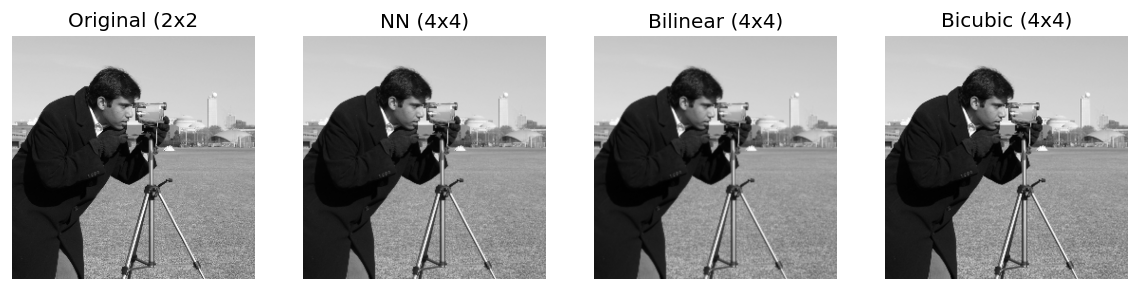

Donw -> Up(NN): PSNR = 25.64 dB
Donw -> Up(Bilinear): PSNR = 27.29 dB
Donw -> Up(Bicubic): PSNR = 26.85 dB


In [63]:
def redimensionar(img, tipo, sx, sy):
    if tipo == 1:
        return resize_nn(img, sx, sy)
    elif tipo == 2:
        return resize_bilinear(img, sx, sy)
    else:
        raise ValueError("Tipo inválido! Use 1 para NN ou 2 para bilinear.")
#return out
  # Simulação de uma imagem 8x8
#img_test = np.arange(64, dtype=np.uint8).reshape((8, 8))

#
# # Redimensionar para o dobro (16x16) usando Nearest Neighbor (tipo=1)
#img_nn_resized = redimensionar(img_test, tipo=1, sx=2.0, sy=2.0)
#print(f"NN Redimensionada: {img_nn_resized.shape}")
#
# # Redimensionar para 1.5x o tamanho (12x12) usando Bilinear (tipo=2)
#img_bilinear_resized = redimensionar(img_test.astype(np.float32), tipo=2, sx=1.5, sy=1.5)
#print(f"Bilinear Redimensionada: {img_bilinear_resized.shape}")
img0 = data.camera().astype(np.float32) / 255.0
io.imsave('data/camera.png', img_as_ubyte(img0))
small= downsample(img0, factor=2, anti_alias=False)
h0, w0 = small.shape

out_nn = redimensionar(small, tipo=1, sx=2.0, sy=2.0)
out_bilinear = redimensionar(small, tipo=2, sx=2.0, sy=2.0)
out_bcubic = sk_resize(small, (int(h0*2), int(w0*2)), order=3, anti_aliasing=False, preserve_range=True).astype(np.float32)

fig, axs = plt.subplots(1,4, figsize=(12,4))
axs[0].imshow(small, cmap='gray'); axs[0].set_title('Original (2x2'); axs[0].axis('off')
axs[1].imshow(out_nn, cmap='gray'); axs[1].set_title('NN (4x4)'); axs[1].axis('off')
axs[2].imshow(out_bilinear, cmap='gray'); axs[2].set_title('Bilinear (4x4)'); axs[2].axis('off')
axs[3].imshow(out_bcubic, cmap='gray'); axs[3].set_title('Bicubic (4x4)'); axs[3].axis('off')
plt.show()

io.imsave('data/camera_small.png', img_as_ubyte(small))
io.imsave('data/camera_out_nn.png', img_as_ubyte(out_nn))
io.imsave('data/camera_out_bilinear.png', img_as_ubyte(out_bilinear))
io.imsave('data/camera_out_bcubic.png', img_as_ubyte(out_bcubic))

print(f"Donw -> Up(NN): PSNR = {psnr(img0, out_nn):.2f} dB")
print(f"Donw -> Up(Bilinear): PSNR = {psnr(img0, out_bilinear):.2f} dB")
print(f"Donw -> Up(Bicubic): PSNR = {psnr(img0, out_bcubic):.2f} dB")

